<a href="https://colab.research.google.com/github/NoahHA/msci-project/blob/master/RNN_multiclass_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install --upgrade tables
!pip install tensorflow-addons==0.8.3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import randint
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from sklearn.utils import class_weight
import tensorflow_addons as tfa
from keras.models import Sequential
from keras.layers import Dense, LSTM, Concatenate, BatchNormalization, Dropout
from keras.regularizers import l2
from keras import Model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import warnings
import math
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.preprocessing import sequence

warnings.filterwarnings("ignore")
%matplotlib inline

Mounted at /content/drive
     |████████████████████████████████| 5.9 MB 5.2 MB/s 
  Attempting uninstall: tables
    Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
     |████████████████████████████████| 1.0 MB 7.5 MB/s 


# Loads in the Dataframes

In [ ]:
# loads the dataframes
higgs_df = pd.read_hdf('/content/drive/MyDrive/Colab Notebooks/ttH.hd5')
semi_leptonic_df = pd.read_hdf('/content/drive/MyDrive/Colab Notebooks/ttsemileptonic.hd5')
fully_leptonic_df = pd.read_hdf('/content/drive/MyDrive/Colab Notebooks/fully_leptonic.hd5')
fully_hadronic_df = pd.read_hdf('/content/drive/MyDrive/Colab Notebooks/fully_hadronic.hd5')


# labels signal vs background
higgs_df["signal"] = 0
semi_leptonic_df["signal"] = 1
fully_hadronic_df["signal"] = 2
fully_leptonic_df["signal"] = 3

# combines the dataframes and randomly shuffles the rows
full_df = higgs_df.append(semi_leptonic_df, ignore_index=True)
full_df = full_df.append(fully_leptonic_df, ignore_index=True)
full_df = full_df.append(fully_hadronic_df, ignore_index=True)
full_df = shuffle(full_df)

event_cols = [
    "BiasedDPhi",
    "DiJet_mass",
    "HT",
    "InputMet_InputJet_mindPhi",
    "InputMet_pt",
    "MHT_pt",
    "MinChi",
    "MinOmegaHat",
    "MinOmegaTilde",
    "ncleanedBJet",
    "ncleanedJet",
]

object_cols = [
    "cleanedJet_pt",
    "cleanedJet_area",
    "cleanedJet_btagDeepB",
    "cleanedJet_chHEF",
    "cleanedJet_eta",
    "cleanedJet_mass",
    "cleanedJet_neHEF",
    "cleanedJet_phi",
]

# removes useless columns
df = full_df[event_cols + object_cols + ["signal", "xs_weight"]]

# Splits data into event / object dataframes and train / test dataframes

In [ ]:
scaler = StandardScaler()

# columns that should not be transformed
untransformed_cols = ["ncleanedBJet", "ncleanedJet", "BiasedDP   hi", "signal"]
transformed_cols = list(set(event_cols) - set(untransformed_cols))

# takes the log of each column to remove skewness
for col_name in event_cols:
    if col_name in transformed_cols:
        df[col_name] = np.log(df[col_name])

# splits data into training and validation
num_classes = 4
X, y = df.drop("signal", axis=1), df["signal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

# divides training data into object level and event level features
event_X_train, event_X_test = X_train[event_cols], X_test[event_cols]
object_X_train, object_X_test = X_train[object_cols], X_test[object_cols]

# scales features so they all have the same mean and variance
event_X_train[event_cols] = scaler.fit_transform(event_X_train[event_cols].values)
event_X_test[event_cols] = scaler.transform(event_X_test[event_cols].values)

max_jets = df["ncleanedJet"].max()

# pads input sequences with zeroes so they're all the same length
for col in object_cols:
    object_X_train[col] = sequence.pad_sequences(
        object_X_train[col].values, padding="post", dtype="float32"
    ).tolist()
    object_X_test[col] = sequence.pad_sequences(
        object_X_test[col].values, padding="post", dtype="float32"
    ).tolist()

# one-hot encodes the label data
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

print(
    "Removed Columns:",
    [col for col in full_df.columns if col not in set(event_cols + object_cols)],
)
X_train.head()

Removed Columns: ['dataset', 'entry', 'InputMet_phi', 'MHT_phi', 'hashed_filename', 'weight_nominal', 'xs_weight', 'signal']


,BiasedDPhi,DiJet_mass,HT,InputMet_InputJet_mindPhi,InputMet_pt,MHT_pt,MinChi,MinOmegaHat,MinOmegaTilde,ncleanedBJet,ncleanedJet,cleanedJet_pt,cleanedJet_area,cleanedJet_btagDeepB,cleanedJet_chHEF,cleanedJet_eta,cleanedJet_mass,cleanedJet_neHEF,cleanedJet_phi,xs_weight
53498,0.215648,6.649490,6.519272,0.293282,5.361879,5.538665,-0.134582,-0.259455,-0.327465,3,5,"[261.52283, 225.8979, 91.63332, 60.87642, 38.1...","[0.5185547, 0.50878906, 0.5385742, 0.44873047,...","[0.041809082, 0.8979492, 0.8051758, 0.01580810...","[0.7890625, 0.30859375, 0.2578125, 0.71875, 0....","[1.7871094, -0.3786621, -0.5546875, -0.5444336...","[47.75, 26.96875, 10.8828125, 11.0, 7.2460938]","[0.05859375, 0.03857422, 0.375, 0.099609375, 0...","[2.2070312, -1.8222656, -2.6152344, -1.2099609...",8.695861e-08
70893,-2.526052,4.900726,6.495144,-0.426435,5.813384,5.957059,-0.001144,-0.058837,-0.892536,1,5,"[280.56213, 192.93166, 114.08489, 37.41686, 36...","[0.46875, 0.42895508, 0.50878906, 0.50878906, ...","[0.8823242, 0.023880005, 0.17456055, 0.1975097...","[0.6796875, 0.65625, 0.5234375, 0.7265625, 0.7...","[0.07965088, -0.34375, 1.4628906, 1.1542969, 2...","[45.4375, 26.484375, 24.09375, 8.0703125, 8.78...","[0.057617188, 0.021972656, 0.06738281, 0.14648...","[-0.23266602, 0.15930176, -2.7148438, 0.739746...",8.695861e-08
237445,-2.903357,4.944532,6.013597,0.112561,5.383922,5.334384,0.236866,0.046075,-0.435882,1,6,"[119.72301, 93.39899, 66.47, 59.607845, 36.527...","[0.50878906, 0.50878906, 0.4987793, 0.47875977...","[0.016937256, 0.99902344, 0.39233398, 0.081909...","[0.5546875, 0.828125, 0.5625, 0.3203125, 0.375...","[0.5024414, 1.3632812, 1.5048828, 1.0673828, -...","[14.796875, 12.0546875, 8.078125, 6.4726562, 6...","[0.12695312, 0.064453125, 0.28125, 0.028808594...","[-2.0078125, -0.97509766, -2.0292969, 2.4375, ...",1.058815e-06
369769,-2.411297,4.779629,5.894305,0.733344,5.312590,5.348103,-0.213008,-0.213008,-0.247638,2,5,"[113.05798, 94.27129, 57.440254, 53.658325, 44...","[0.4987793, 0.5385742, 0.48876953, 0.50878906,...","[0.98095703, 0.039886475, 0.9975586, 0.0235748...","[0.40625, 0.3203125, 0.578125, 0.671875, 0.46875]","[-0.9272461, -0.6621094, 1.0400391, 1.9550781,...","[19.484375, 11.9375, 11.03125, 10.40625, 9.960...","[0.0, 0.0, 0.09375, 0.06201172, 0.3515625]","[-2.0605469, -0.8691406, -2.5761719, -1.215820...",1.058815e-06
182176,-1.819252,4.588222,5.998631,0.135848,5.521461,5.566051,0.324697,0.009486,-0.308683,1,5,"[164.34547, 121.036934, 41.481316, 40.9428, 35...","[0.50878906, 0.48876953, 0.55859375, 0.4987793...","[0.06738281, 0.38891602, 0.15673828, 0.0328063...","[0.265625, 0.7109375, 0.3046875, 0.7109375, 0....","[0.57421875, 1.1523438, 1.484375, -0.39672852,...","[22.796875, 16.828125, 9.28125, 6.9335938, 7.2...","[0.053710938, 0.08300781, 0.5078125, 0.0, 0.03...","[0.38623047, 0.006702423, -1.3300781, -2.33007...",1.058815e-06


# Loads data

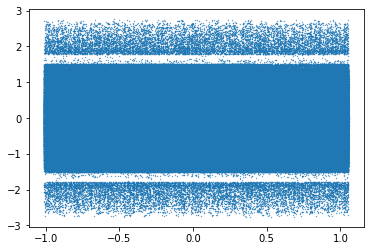

In [ ]:
# object data
object_X_train = np.load('/content/drive/MyDrive/RNN_classifier/object_X_train_multiclass.npy')
object_X_test = np.load('/content/drive/MyDrive/RNN_classifier/object_X_test_multiclass.npy')

plt.scatter(object_X_train[:, :, 7], object_X_train[:, :, 4], s=0.1) # plots (eta, phi) for all jets

# Hyperparameters

In [ ]:
# hyperparameters
lr = 0.001
activation = "relu"
batch_size = 32
num_classes = 4
lstm_l2 = 0 #1e-6
mlp_l2 = 0 #1e-4

optimizer = keras.optimizers.Adam(
    learning_rate=lr,
)

METRICS = [
    keras.metrics.CategoricalAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name='AUC'),
]

y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_integers), y=y_integers
)

class_weights = {l: c for l, c in zip(np.unique(y_integers), class_weights)}

# Callbacks

In [ ]:
monitor = 'val_loss'
mode = 'auto'

# stops training early if score doesn't improve
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,
    verbose=1,
    patience=6,
    mode=mode,
    restore_best_weights=True,
)

# saves the network at regular intervals so you can pick the best version
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/RNN_classifier/best_model_multiclass_v2.h5",
    monitor=monitor,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode=mode,
    save_freq="epoch",
)

# reduces the lr whenever training plateaus
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor=monitor,
    factor=0.1,
    patience=3,
    mode=mode,
)

# Defines and compiles the model

In [ ]:
DNN_model = Sequential([
        Dense(40, input_shape=(event_X_train.shape[1],), activation=activation, kernel_regularizer=l2(mlp_l2)),
        BatchNormalization()])

RNN_model = Sequential([
        LSTM(
            200,
            input_shape=(object_X_train.shape[1], object_X_train.shape[2]),
            activation="tanh",
            unroll=False,
            recurrent_dropout=0.0,
            kernel_regularizer=l2(lstm_l2)),
        BatchNormalization()])

merged = Concatenate()([DNN_model.output, RNN_model.output])

merged = BatchNormalization()(merged)
merged = Dense(40, activation=activation, kernel_regularizer=l2(mlp_l2))(merged)
merged = Dense(num_classes, activation="softmax")(merged)

model = Model(inputs=[DNN_model.input, RNN_model.input], outputs=merged)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=METRICS)

# plots the model as a graph
#keras.utils.plot_model(model, "RNN_multiclass_model_diagram.png", show_shapes=True, show_layer_names=False)

# Loads pre-trained model

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/RNN_classifier/best_model_multiclass_v2.h5')

# Trains the model

In [ ]:
history = model.fit(
    [event_X_train, object_X_train],
    y_train,
    batch_size=32,
    class_weight=class_weights,
    epochs=6,
    callbacks=[early_stopping, checkpoint],
    validation_data=([event_X_test, object_X_test], y_test),
    verbose=1,
)

# 0.8604

Epoch 1/6
9586/9586 [==============================] - ETA: 0s - loss: 1.1608 - accuracy: 0.4910 - precision: 0.5571 - recall: 0.2625 - AUC: 0.7541
Epoch 00001: val_loss improved from 2.76207 to 0.94436, saving model to /content/drive/MyDrive/RNN_classifier/best_model_multiclass_v2.h5
9586/9586 [==============================] - 360s 38ms/step - loss: 1.1608 - accuracy: 0.4910 - precision: 0.5571 - recall: 0.2625 - AUC: 0.7541 - val_loss: 0.9444 - val_accuracy: 0.6109 - val_precision: 0.6895 - val_recall: 0.3880 - val_AUC: 0.8433
Epoch 2/6
9585/9586 [============================>.] - ETA: 0s - loss: 1.1313 - accuracy: 0.4987 - precision: 0.5762 - recall: 0.2800 - AUC: 0.7613
Epoch 00002: val_loss improved from 0.94436 to 0.93611, saving model to /content/drive/MyDrive/RNN_classifier/best_model_multiclass_v2.h5
9586/9586 [==============================] - 361s 38ms/step - loss: 1.1313 - accuracy: 0.4987 - precision: 0.5762 - recall: 0.2800 - AUC: 0.7613 - val_loss: 0.9361 - val_accuracy

KeyboardInterrupt: ignored

# Evaluates the model

In [ ]:
y_pred_test = model.predict([event_X_test, object_X_test])

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'precision', 'recall', 'AUC']
  fig = plt.figure(figsize=(14, 14))

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ")
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
  
    plt.xlabel('Epoch')
    plt.ylabel(name)

    plt.legend()

plot_metrics(history)

In [ ]:
def compare_models(history, history2):
  metrics = ['loss', 'accuracy', 'precision', 'recall', 'AUC']
  fig = plt.figure(figsize=(14, 14))

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ")
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Model 1 Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Model 1 Val')
    plt.plot(history2.epoch, history2.history[metric], label='Model 2 Train')
    plt.plot(history2.epoch, history2.history['val_'+metric],
             linestyle="--", label='Model 2 Val')
    
    plt.xlabel('Epoch')
    plt.ylabel(name)

    plt.legend()

compare_models(history, history2)

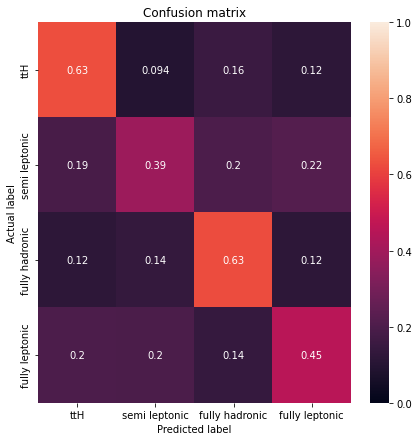

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  signal_types = ['ttH', 'semi leptonic', 'fully hadronic', 'fully leptonic']

  cm = confusion_matrix(labels, predictions, normalize='true')
  plt.figure(figsize=(7, 7))
  sns.heatmap(cm, annot=True, xticklabels=signal_types, yticklabels=signal_types, vmin=0, vmax=1)

  plt.title(f'Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

plot_cm(y_test.argmax(axis=1), y_pred_test.argmax(axis=1))

# Significance as a Function of Threshold

In [ ]:
preds = model.predict([event_X_test, object_X_test])

0.36734693877551017


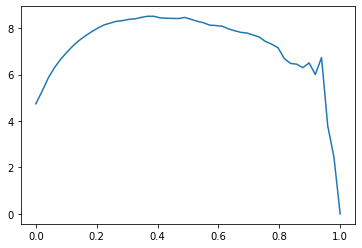

In [ ]:
test_weight = X_test["xs_weight"].values
test_frac = len(y_test) / len(y_train)

thresholds = np.linspace(0, 1, 50)
significance = np.zeros(len(thresholds), dtype=float)

lum = 140e3
epsilon = 1e-5

sg = np.zeros(len(thresholds))
bg = np.zeros(len(thresholds))
labels = [y.argmax() for y in y_test]

for i, threshold in enumerate(thresholds):
    sg[i] = sum([test_weight[j] for j, (pred, label) in enumerate(zip(preds, labels)) if (pred[0] >= threshold and label == 0)]) * lum / test_frac
    bg[i] = sum([test_weight[j] for j, (pred, label) in enumerate(zip(preds, labels)) if (pred[0] >= threshold and label != 0)]) * lum / test_frac

significance = sg / np.sqrt(bg + epsilon)

index = significance.argmax()
print(thresholds[index])

plt.plot(thresholds, significance)
plt.show()

# Discriminator Plots

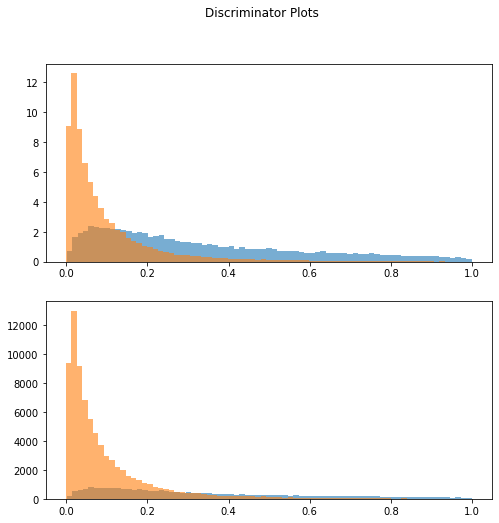

In [ ]:
test_weight = X_test["xs_weight"].values
labels = [y.argmax() for y in y_test]

signals = [pred[0] for label, pred in zip(labels, preds) if label == 0]
backgrounds = [pred[0] for label, pred in zip(labels, preds) if label != 0]

n_bins = 75
alpha = 0.6

fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))

fig.suptitle('Discriminator Plots')
ax1.hist(signals, density=True, bins=n_bins, alpha=alpha)
ax1.hist(backgrounds, density=True, bins=n_bins, alpha=alpha)
ax2.hist(signals, density=False, bins=n_bins, alpha=alpha)
ax2.hist(backgrounds, density=False, bins=n_bins, alpha=alpha)

plt.show()